In [1]:
library(Seurat)
library(pheatmap)
library(purrr)
library(dplyr)
library(stringr)
library(ComplexHeatmap)
library(AUCell)
library(GSEABase)
library(reshape2)
library(circlize)
library(ggplot2)
library(plyr)
suppressMessages(library(clusterProfiler))

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))
! pheatmap() has been masked by ComplexHeatmap:

# survival

## myeloid

In [2]:
library(survival)
library(data.table)
library(stringr)
library(survminer)
library(ggsurvfit)
library(purrr)
library(plyr)
library(readr)
library(tidyverse)  


Attaching package: ‘data.table’


The following objects are masked from ‘package:reshape2’:

    dcast, melt


The following object is masked from ‘package:IRanges’:

    shift


The following objects are masked from ‘package:S4Vectors’:

    first, second


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: ggpubr


Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    mutate



Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma


── Attaching core tidyverse packages ──────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%within%()        masks IRanges::%within%()
✖ cl

In [3]:
expr = fread('~/HPV/data/rna/tcga/RNA',header = T, sep = '\t')
expr = as.data.frame(expr)
rownames(expr) = expr[,1]
expr = expr[,-1]

table(unlist(lapply(colnames(expr), function(x){
    unlist(str_split(x,'-'))[4]
})))
expr = expr[,str_which(colnames(expr),'-01')]


 01  06  11 
303   2   3 

In [4]:
squamous = read.table('~/HPV/data/rna/tcga/squamous_patient.tsv',header = TRUE,sep = '\t')

In [5]:
survive = read.table('~/HPV/data/rna//tcga//Survival',header = TRUE,sep = '\t')
survive = survive[str_which(survive$sample,'-01'),]

In [6]:
patient = list(unique(squamous$Case.ID), gsub('-01','',colnames(expr),survive$X_PATIENT)) %>% purrr::reduce(intersect)
expr = expr[,which(gsub('-01','',colnames(expr)) %in% patient)]
survive = survive[survive$X_PATIENT %in% patient,]

In [7]:
colnames(expr) = gsub('-01','',colnames(expr))
expr = expr[,patient]
rownames(survive) = survive$X_PATIENT
survive = survive[patient,]

In [8]:
degs = list.files('~/HPV/res/public_rna/seurat_rds/degs/',pattern = 'curated',full.names = TRUE)
degs = degs %>% map(read.table, header = TRUE, sep = '\t')
degs = degs %>% purrr::reduce(rbind)
degs = degs[!str_detect(degs$gene,'^KRT|AC[0-9]|ACTB'),]
degs = degs[!(str_detect(degs$gene,'^IGH|^IGK') & !str_detect(degs$cluster,'^Plasma|Bmem')),]

In [9]:
cts1 = c('Mph_CCL20','Mph_SLC2A1','Neutrophil_VEGFA','Neutrophil_IFIT1')
cts2 = c('Mph_NR4A3','cDC_LAMP3','Neutrophil_CCL4')
cts = c(cts1,cts2)

In [10]:
for (cluster in cts){
    degs_sub = degs[degs$cluster==cluster,]
    degs_sub = degs_sub[1:30,]
    common_genes = intersect(degs_sub$gene, rownames(expr))
    survive[,cluster] = scale(colMeans(expr[common_genes,]))[,1]
}
cts_sub = cts[!str_detect(cts,'^EC|CAF')]
cts_sub = cts
formula = paste('Surv(OS.time,OS) ~', cts_sub[1])
for (ct in cts_sub[2:length(cts_sub)]){
    formula = paste(formula, '+', ct)
}
write.table(survive,file = '~/HPV/res/public_rna/proportion/cor1/survive_cluster_feature.txt',col.names = TRUE,row.names = FALSE,quote = FALSE,sep = '\t')

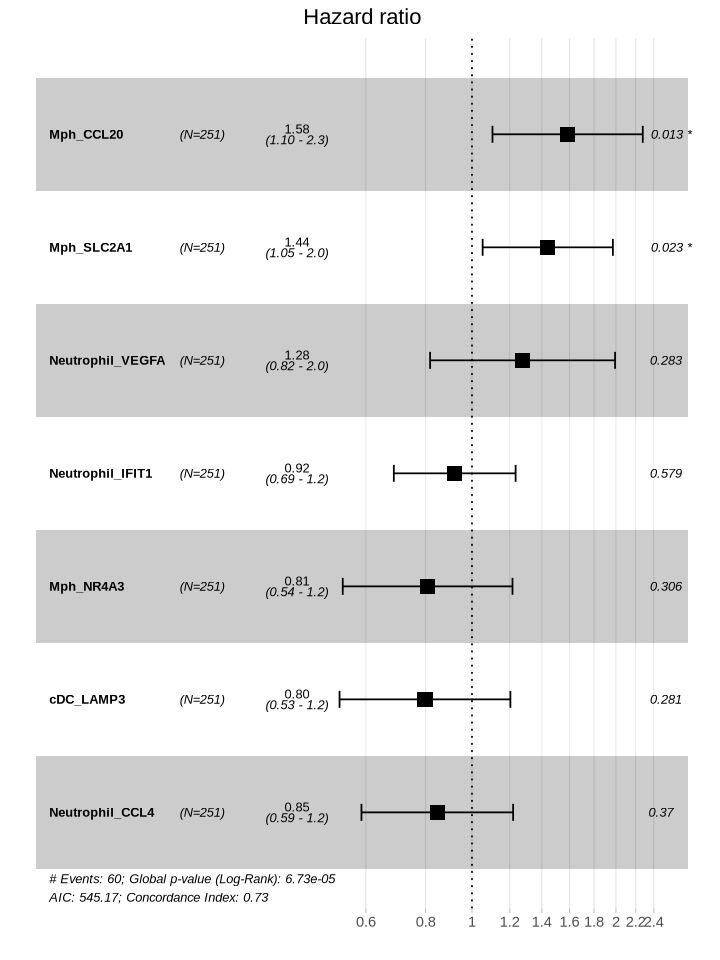

In [11]:
res = coxph(as.formula(formula), data = survive)
saveRDS(res,file = '~/HPV/res/public_rna/proportion/cor1/coxph.rds')
options(repr.plot.width = 6, repr.plot.height = 8)
ggforest(res, data=survive)

In [12]:
temp = summary(res)
temp = as.data.frame(cbind(signif(temp$coefficients),signif(temp$conf.int)))
temp$ct = rownames(temp)

In [13]:
temp$ct = factor(temp$ct,levels = temp$ct)
temp$environment = 'a'
temp$environment[temp$ct %in% cts1] = 'IS'
temp$environment[temp$ct %in% cts2] = 'IA'
temp$environment = factor(temp$environment,levels = c('IS','IA'))

In [14]:
colnames(temp)[2] = 'mid'
colnames(temp)[5] = 'p'
colnames(temp)[8] = 'lower'
colnames(temp)[9] = 'upper'

In [15]:
saveRDS(temp,file = '~/HPV/res/public_rna/proportion/cor1/coxph_plot.rds')

## epi

In [18]:
Idents(epi) = 'curated'
degs = FindAllMarkers(epi,return.thresh = 0.05,logfc.threshold = 0.5, only.pos = TRUE)

Calculating cluster Epi_Hypoxia

Calculating cluster Epi_Normoxia



In [19]:
table(degs$cluster)


 Epi_Hypoxia Epi_Normoxia 
         278          183 

In [20]:
library(survival)
library(data.table)
library(stringr)
library(survminer)
library(ggsurvfit)

In [21]:
expr = fread('~/HPV/data/rna/tcga/RNA',header = T, sep = '\t')
expr = as.data.frame(expr)
rownames(expr) = expr[,1]
expr = expr[,-1]

table(unlist(lapply(colnames(expr), function(x){
    unlist(str_split(x,'-'))[4]
})))
expr = expr[,str_which(colnames(expr),'-01')]


 01  06  11 
303   2   3 

In [22]:
squamous = read.table('~/HPV/data/rna/tcga/squamous_patient.tsv',header = TRUE,sep = '\t')

In [23]:
survive = read.table('~/HPV/data/rna/tcga/Survival',header = TRUE,sep = '\t')
survive = survive[str_which(survive$sample,'-01'),]

In [24]:
patient = list(unique(squamous$Case.ID), gsub('-01','',colnames(expr),survive$X_PATIENT)) %>% purrr::reduce(intersect)
expr = expr[,which(gsub('-01','',colnames(expr)) %in% patient)]
survive = survive[survive$X_PATIENT %in% patient,]

In [25]:
table(survive$OS)


  0   1 
191  60 

In [26]:
colnames(expr) = gsub('-01','',colnames(expr))
expr = expr[,patient]
rownames(survive) = survive$X_PATIENT
survive = survive[patient,]

In [27]:
for (cluster in unique(degs$cluster)){
    degs_sub = degs[degs$cluster==cluster,] %>% arrange(desc(avg_log2FC))
    degs_sub = degs_sub[1:10,]
    common_genes = intersect(degs_sub$gene, rownames(expr))
    rownames(degs_sub) = degs_sub$gene
    degs_sub = degs_sub[common_genes,]
    print(length(common_genes))
    for (i in 1:nrow(survive)){
        survive[i,cluster] = mean(expr[common_genes,i])
    }
}

[1] 9
[1] 10


$Epi_Hypoxia


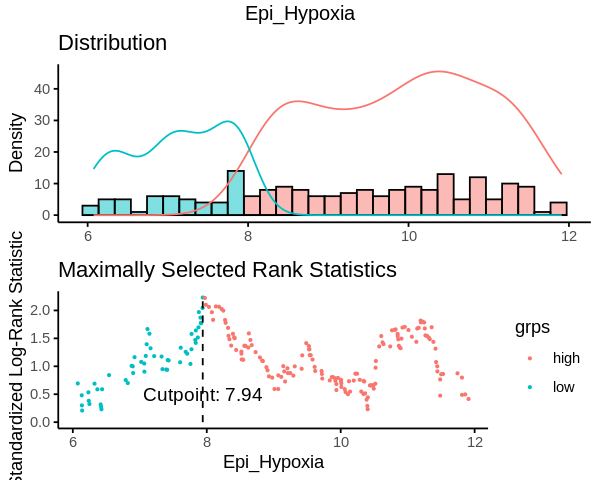

In [28]:
res.cut <- surv_cutpoint(survive, time = "OS.time", event = "OS",
                         variables = c("Epi_Hypoxia") # 找这3个变量的最佳切点
                         )
options(repr.plot.width = 5, repr.plot.height = 4)
plot(res.cut,'Epi_Hypoxia')

In [29]:
res.cut

            cutpoint statistic
Epi_Hypoxia 7.939978  2.231667

In [30]:
sur = function(survive){
    p = survfit2(Surv(OS.time,OS) ~ signature, data = survive[survive$signature!='others',]) %>% 
      ggsurvfit() + 
        add_risktable(risktable_stats = 'n.risk', theme = theme_test()+
                      theme(axis.title = element_blank(),title = element_blank(),
                            axis.text.x = element_blank(),
                            axis.ticks.x=element_blank(),
                            axis.text.y = element_text(color="black",size=10)),
                    combine_groups=F,risktable_height = 0.23) +
        annotate(geom = "text", x = 0, y = 0.2, label = paste0('P = ',p.value) ,hjust = 0, vjust = 1) + 
        scale_x_continuous(breaks = seq(0,6000,1000)) + 
        theme_classic() + 
        theme(legend.position = c(0.8,0.8),axis.title.x = element_text(size = 13),axis.title.y = element_text(size = 13),
              axis.text.x = element_text(size = 12),
              axis.text.y = element_text(size = 12),
              legend.text = element_text(size = 11),
            ) + 
        scale_color_manual(values = colors,
                            breaks = c('High', 'Low'),
                            labels = c('High', 'Low'))
    return(p)
}

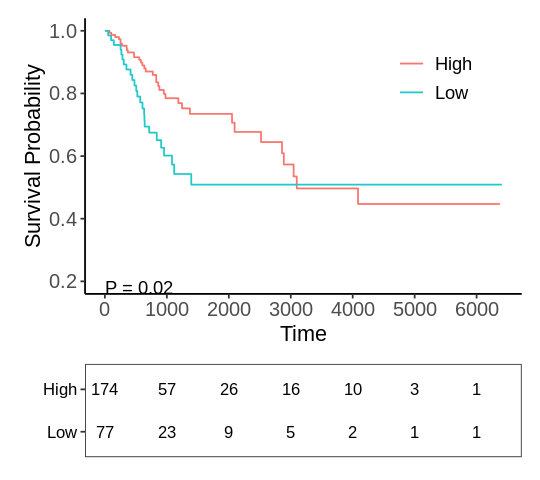

In [31]:
survive$signature = c('others')
survive$signature[survive$Epi_Hypoxia >= 7.939978] = 'High'
survive$signature[survive$Epi_Hypoxia < 7.939978] = 'Low'
colors = c("#F8766D", "#22C8CC")
names(colors) = c('High', 'Low')
res = survdiff(Surv(OS.time,OS) ~ signature, data = survive[survive$signature!='others',])
p.value <- round(1 - pchisq(res$chisq, length(res$n) -1),digits = 2)
#plot
options(repr.plot.width = 4.5, repr.plot.height = 4)
sur(survive)

In [32]:
saveRDS(survive,file = '~/HPV/res/public_rna/proportion/cor1/survive.rds')

# mph

In [33]:
mph = readRDS('~/HPV/res/public_rna/seurat_rds/annotated/mph.rds')

In [34]:
angiogenesis = read.table('./features/angiogenesis.txt',header = FALSE)[,1]
hypoxia = read.gmt('~/HPV/ref/pathways/h.all.v2023.1.Hs.symbols.gmt')
hypoxia = hypoxia[hypoxia$term == 'HALLMARK_HYPOXIA',2]
mhcii = rownames(mph)[str_detect(rownames(mph),'^HLA-D')]
modules = list(angiogenesis,hypoxia,mhcii)
names(modules) = c('Angiogenesis','Hypoxia','MHCII')
moduleGeneSets <- c()
for(i in 1:length(modules)){
    moduleGeneSets <- c(moduleGeneSets, GeneSet(modules[[i]], setName = names(modules)[i]))
}
geneSets <- GeneSetCollection(moduleGeneSets)

In [35]:
cells_AUC <- AUCell_run(mph@assays$RNA@data, geneSets)

In [36]:
res = cells_AUC@assays@data$AUC %>% reshape2::melt()

In [37]:
head(res)

,gene sets,cells,value
,<fct>,<fct>,<dbl>
1,Angiogenesis,AACACACTCGGCACTG-1_1_1,0.12191693
2,Hypoxia,AACACACTCGGCACTG-1_1_1,0.14824926
3,MHCII,AACACACTCGGCACTG-1_1_1,0.64737485
4,Angiogenesis,AACCAACCAGGATCTT-1_1_1,0.09124601
5,Hypoxia,AACCAACCAGGATCTT-1_1_1,0.10681475
6,MHCII,AACCAACCAGGATCTT-1_1_1,0.50891331


In [38]:
res$cts = rep(mph$curated,each = 3)

In [39]:
colnames(res) = c('Geneset','Cell','Score','Celltype')

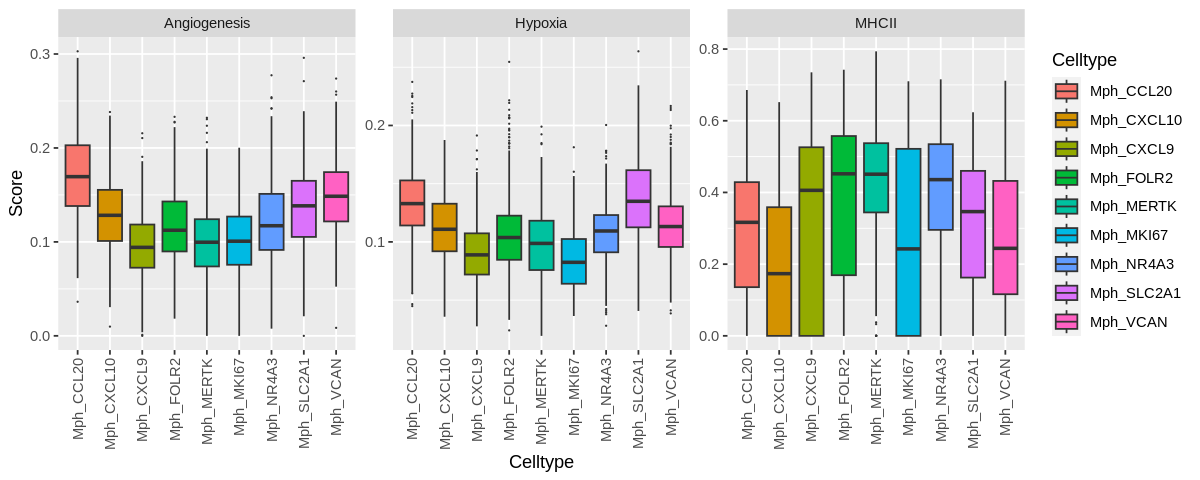

In [40]:
options(repr.plot.width = 10, repr.plot.height = 4)
ggplot(res) + geom_boxplot(aes(x = Celltype, y = Score, fill = Celltype),outlier.size = 0) + facet_wrap(.~Geneset,scales = 'free') + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

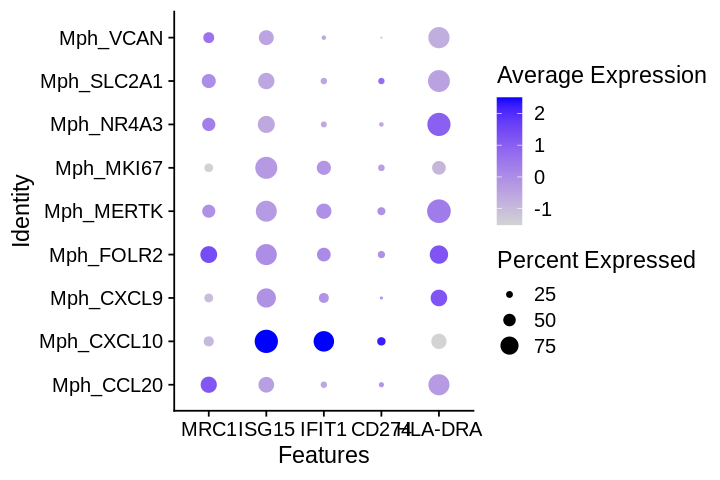

In [41]:
options(repr.plot.width = 6, repr.plot.height = 4)
DotPlot(mph,features = c('MRC1','ISG15','IFIT1','CD274','HLA-DRA'),group.by = 'curated')

In [42]:
saveRDS(res,file = '~/HPV/res/public_rna/proportion/cor1/mph.rds')

# cd8t

In [2]:
cd8t = readRDS('~/HPV/res/public_rna/seurat_rds/annotated/cd8t.rds')

In [3]:
marker_genes = c('LEF1','SELL','TCF7','CCR7','KLF2','IL7R','PDCD1','TIGIT','HAVCR2','LAG3','CTLA4','TOX','ENTPD1','GZMA','GZMB','GZMK','PRF1','GNLY','IFNG','CCL3','CCL5','CXCL9','CXCL10','CXCL13','XCL1','MKI67','STMN1','TOP2A')

In [4]:
gene_cell_exp <- AverageExpression(cd8t,
                                   features = c(marker_genes),
                                   group.by = 'curated',
                                   slot = 'data') 
gene_cell_exp <- as.data.frame(gene_cell_exp$RNA)
marker_exp <- t(scale(t(gene_cell_exp),scale = T,center = T))

In [5]:
colnames(marker_exp)

[1] "CD8Tcc_MKI67"    "CD8Tcc_STMN1"    "CD8Tcm_ANXA1"    "CD8Teff_CCL3"   
 [5] "CD8Teff_GNLY"    "CD8Teff_GZMK"    "CD8Teff_XCL1"    "CD8Tem_GZMK"    
 [9] "CD8Tem_TOX"      "CD8Tex_ENTPD1"   "CD8Texint_TOX"   "CD8Tnaive_BACH2"
[13] "CD8Tnaive_LEF1"  "CD8Tnaive_LTB"   "CD8Tpex_TCF7"    "CD8Trm_ZNF683"

In [6]:
saveRDS(marker_exp,file = '~/HPV/res/public_rna/proportion/cor1/cd8t.rds')

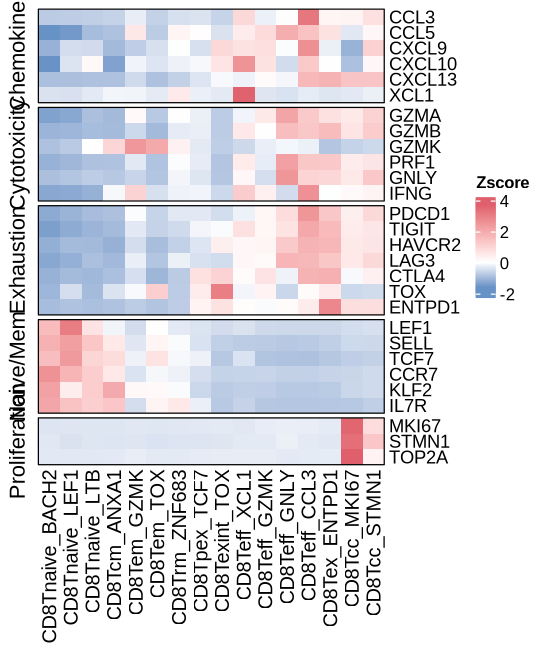

In [7]:
col_fun <- colorRamp2(
  c(min(marker_exp),0, max(marker_exp)), 
  c("#6792C5",'white',"#DF606C")
)
row_split = c(rep('Naive/Mem',6),rep('Exhaustion',7),rep('Cytotoxicity',6),rep('Chemokine',6), rep('Proliferation',3))
options(repr.plot.width = 4.5, repr.plot.height = 5.5)
draw(Heatmap(marker_exp,border = TRUE,cluster_rows = FALSE,col = col_fun,cluster_columns = FALSE,row_names_gp = gpar(fontsize=11),name = 'Zscore',column_order = c('CD8Tnaive_BACH2', 'CD8Tnaive_LEF1', 'CD8Tnaive_LTB', 'CD8Tcm_ANXA1','CD8Tem_GZMK','CD8Tem_TOX','CD8Trm_ZNF683','CD8Tpex_TCF7','CD8Texint_TOX','CD8Teff_XCL1','CD8Teff_GZMK','CD8Teff_GNLY','CD8Teff_CCL3','CD8Tex_ENTPD1','CD8Tcc_MKI67','CD8Tcc_STMN1')),row_split = row_split)

# neutrophil

In [49]:
neu = readRDS('~/HPV/res/public_rna/seurat_rds/annotated/neutrophil.rds')

In [50]:
angiogenesis = read.table('./features/angiogenesis.txt',header = FALSE)[,1]
modules = list(angiogenesis)
names(modules) = c('Angiogenesis')
moduleGeneSets <- c()
for(i in 1:length(modules)){
    moduleGeneSets <- c(moduleGeneSets, GeneSet(modules[[i]], setName = names(modules)[i]))
}
geneSets <- GeneSetCollection(moduleGeneSets)

In [51]:
cells_AUC <- AUCell_run(neu@assays$RNA@data, geneSets)

In [52]:
res = cells_AUC@assays@data$AUC %>% reshape2::melt()

In [53]:
head(res)

,gene sets,cells,value
,<fct>,<fct>,<dbl>
1,Angiogenesis,ZAM1_ZAM1_CTCGAGGAGAAACCCG-1_1,0.17963791
2,Angiogenesis,ZAM1_ZAM1_TTCCAATAGAATCTAG-1_1,0.16719915
3,Angiogenesis,AAGTGAAGTGTCCGGT-1_1_1_1_1_1_1_1,0.11514377
4,Angiogenesis,AGGAATAGTGAGAACC-1_1_1_1_1_1_1_1,0.05972311
5,Angiogenesis,CAGTTCCGTATTTCCT-1_1_1_1_1_1_1_1,0.07574015
6,Angiogenesis,CAGTTCCTCTCTTCAA-1_1_1_1_1_1_1_1,0.05444089


In [54]:
res$cts = neu$curated

In [55]:
colnames(res) = c('Geneset','Cell','Score','Celltype')

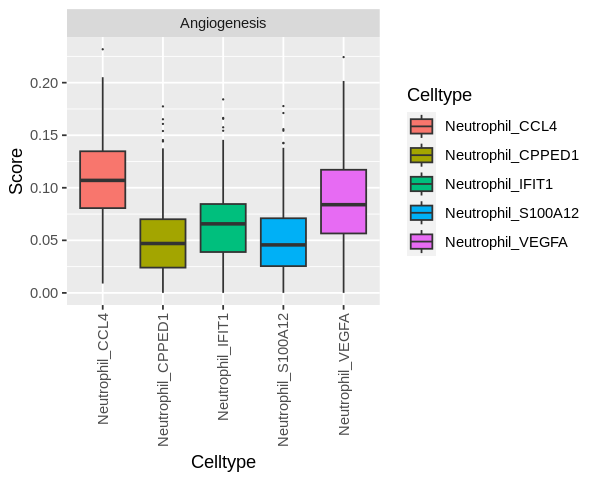

In [56]:
options(repr.plot.width = 5, repr.plot.height = 4)
ggplot(res) + geom_boxplot(aes(x = Celltype, y = Score, fill = Celltype),outlier.size = 0) + facet_wrap(.~Geneset,scales = 'free') + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [57]:
saveRDS(res,file = '~/HPV/res/public_rna/proportion/cor1/neu.rds')

# NK

In [58]:
nk = readRDS('~/HPV/res/public_rna/seurat_rds/annotated/nk.rds')

In [59]:
cyto = c('GZMA', 'GZMB', 'GZMH', 'GZMM', 'GZMK', 'GNLY', 'PRF1', 'CTSW')
inflam = c('CCL2', 'CCL3', 'CCL4', 'CCL5', 'CXCL10', 'CXCL9', 'IL1B', 'IL6', 'IL7', 'IL15', 'IL18')
# hlaIreceptor = c('KIR2DL1', 'KIR2DL3', 'KIR3DL1', 'KIR3DL2', 'LILRB1', 'LAG3')
# Ireceptor = c('PDCD1', 'SIGLEC7', 'CD300A', 'CD96', 'IL1RAPL1', 'TIGIT', 'HAVCR2')
# hlaAreceptor = c('KIR2DL4', 'CD160', 'KLRC2')       
# Areceptor = c('NCR3', 'NCR1', 'KLRK1', 'CRTAM', 'FCGR3A') 
modules = list(cyto,inflam)
names(modules) = c('Cytotoxicity','Inflammatory')
# modules = list(cyto,inflam,hlaIreceptor,Ireceptor,hlaAreceptor,Areceptor)
# names(modules) = c('cyto','inflam','hlaIreceptor','Ireceptor','hlaAreceptor','Areceptor')

In [60]:
moduleGeneSets <- c()
for(i in 1:length(modules)){
    moduleGeneSets <- c(moduleGeneSets, GeneSet(modules[[i]], setName = names(modules)[i]))
}
geneSets <- GeneSetCollection(moduleGeneSets)

In [61]:
cells_AUC <- AUCell_run(nk@assays$RNA@data, geneSets)

In [62]:
res = cells_AUC@assays@data$AUC %>% melt

Warning message in melt(.):
"The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In the next version, this warning will become an error."


In [63]:
res$cts = rep(nk$curated,each = 2)

In [64]:
colnames(res) = c('Geneset','Cell','Score','Celltype')

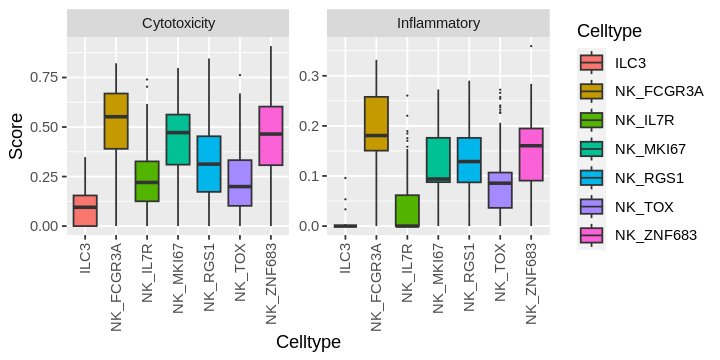

In [65]:
options(repr.plot.width = 6, repr.plot.height = 3)
ggplot(res) + geom_boxplot(aes(x = Celltype, y = Score, fill = Celltype),outlier.size = 0) + facet_wrap(.~Geneset,scales = 'free') + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [66]:
saveRDS(res,file = '~/HPV/res/public_rna/proportion/cor1/nk.rds')